# K-Means Clustering

Unsupervised machine learning models: clustering algorithms. Clustering algorithms seek to learn from the properties of the data, an optimal division or discrete labeling of groups of points. Therefore, I will go throught basic understanding and implementing the simplest algorithm as k-means clustering.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yellowbrick as yb
import warnings

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

## Introduction

The k-means algorithm searches for a K number of clusters within an unlabeled multidimensional dataset. The idea of the K-Means algorithm is to find K-centroid points and every point in the dataset will belong to the clusters having minimum distance.

It accomplishes this using a simple conception of what the optimal clustering looks like:
* The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
* Each point is closer to its own cluster center than to other cluster centers.

First, let's generate a two-dimensional dataset containing four distinct blobs. To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

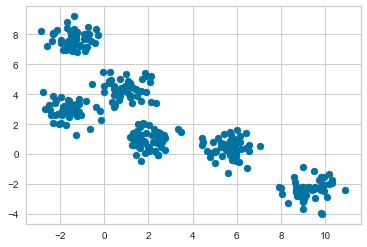

In [4]:
from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples=300, centers=6, cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

Using k-means algorithm `KMeans` in Scikit-Learn easily to pick out the four clusters.

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator

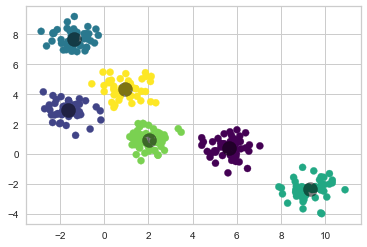

In [6]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(6,4))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

It is the simple k-means algorithm application that assigns the points to clusters very similarly to how we might assign them. However, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly. Instead, the typical approach to k-means involves an intuitive iterative approach known as **expectation–maximization**.

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here. In short, the expectation–maximization approach here consists of the following procedure:

* Guess some cluster centers
* Repeat until converged
    + E-Step: assign points to the nearest cluster center
    + M-Step: set the cluster centers to the mean
    
Here the Expectation step is because it involves **updating our expectation of which cluster each point belongs to**. The Maximization step is so-named because it involves **maximizing some fitness function that defines the location of the cluster centers**. In this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

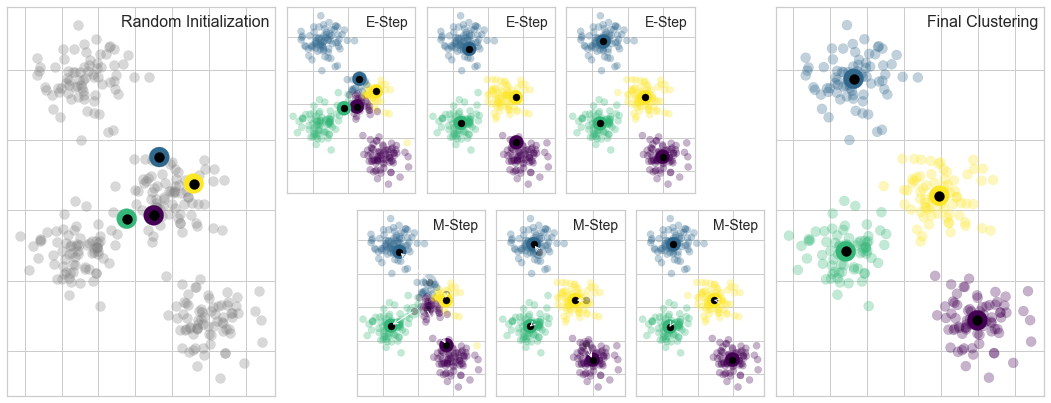

In [7]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 6))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)

plt.show()

### Implementing basic K-Means Algorithm

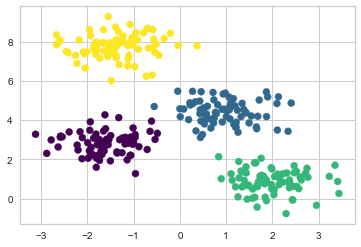

In [11]:
from sklearn.metrics import pairwise_distances_argmin
from random import sample

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    # rng = np.random.RandomState(rseed)
    # i = rng.permutation(X.shape[0])[:n_clusters]
    i = sample(range(X.shape[0]), n_clusters)
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()

### Global optimalizaiton not achieved

First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

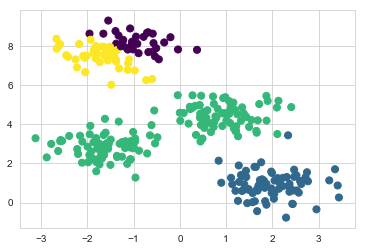

In [11]:
centers, labels = find_clusters(X, 4, rseed=3)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

plt.show()

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the `n_init` parameter, which defaults to 10).

### Pre-selected number of clusters

Another common challenge with k-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data. The Elbow method is a technique to select the optimal number of clusters by fitting the model with a range of clusters.
* Distortion: sum of squared distances from each point to tis assigned center
* Silhouette: ratio of intra-cluster and nearest-cluster distance
* Calinski_harabasz: ratio of within to between cluster dispersion

Silhouette Score
It's used to evaluate the quality of clusters such as K-Means in terms of measuring how well a point is smiliar to its own cluster compared to other clusters. To calculate the Silhouette score ($S$) for each observation, we need two distance metrics:
* Mean intra-cluster distance ($a$): average distance between the observation and all other data points in the same cluster
* Mean nearest-cluster distance ($b$): average distance between the observation and all other data points of the next nearest cluster

$$
S_i = \frac{b_i - a_i}{max(a_i, b_i)}
$$

The value of the score varies from -1 to 1, and a high value indicates the cluster is dense and well-separated than other clusters. A value near 0 represents the observation is very close to the decision boundary of the neighboring clusters. A negative score means the observation has been assigned to the wrong clusters. 

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models), or which can choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the sklearn.cluster submodule)

### k-means is limited to linear cluster boundaries

The fundamental model assumptions of k-means: **points will be closer to their own cluster center than to others** means that the algorithm will often be ineffective if the clusters have complicated geometries. In particular, the boundaries between k-means clusters will always be linear, which means that **it will fail for more complicated boundaries**.

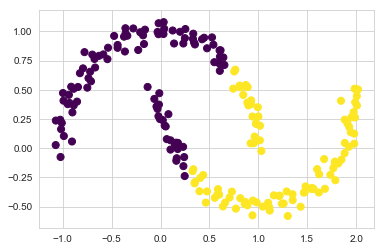

In [12]:
from sklearn.datasets import make_moons

X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

plt.show()

This situation is reminiscent of the discussion in In-Depth: Support Vector Machines, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.

We might imagine using the same trick to allow k-means to discover non-linear boundaries. One version of this kernelized k-means is implemented in Scikit-Learn within the `SpectralClustering` estimator. **It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm**:

E:\Program Files\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


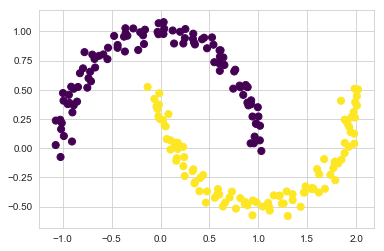

In [13]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

plt.show()

### k-means can be slow for large numbers of samples

Because each iteration of k-means must go over every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based k-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`.

## Example: Clustering on Digital Images

Let's take a look at applying k-means on the same simple digits data. Here we will attempt to use k-means to try to identify similar digits without using the original label information; **this might be similar to a first step in extracting meaning from a new dataset about which you don't have any a priori label information**.

We will start by loading the digits and then finding the KMeans clusters. Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [15]:
from sklearn.datasets import load_digits

# load digits images
digits = load_digits()
print('Original input digits data:', digits.data.shape)

# clustering 10 nodes using k-means
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
print('Clustering digits data: ', kmeans.cluster_centers_.shape)

Original input digits data: (1797, 64)
Clustering digits data:  (10, 64)


The result is 10 clusters in 64 dimensions. Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster. We see that even without the labels, `KMeans` is able to find clusters whose centers are recognizable digits.

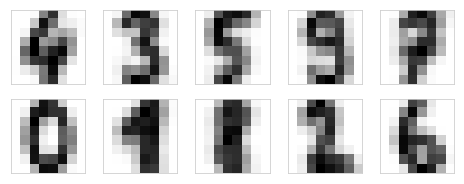

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Now we can define our predicted labels and check how accurate our unsupervised clustering was in finding similar digits within the data:

K-Means Accuracy:  0.9326655537006121


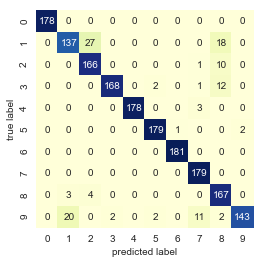

In [77]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

labels = np.zeros(clusters.shape)
for i in range(10):
    # find each clsuter points
    mask = (clusters == i)
    # assign majority true value to our label
    labels[mask] = mode(digits.target[mask])[0]
    
print('K-Means Accuracy: ', accuracy_score(digits.target, labels))

# confusion matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='YlGnBu',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.

Let's try to use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to preprocess the data before performing k-means. **The t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters**.

T-SNE Accuracy:  0.9326655537006121


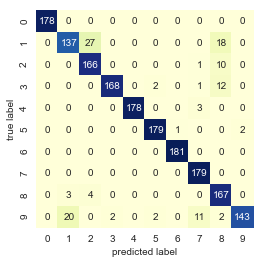

In [79]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
print('T-SNE Accuracy: ', accuracy_score(digits.target, labels))

# confusion matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='YlGnBu',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()